#### В этом ноутбуке:
- мы делаем обзор данных  
- визуализируем горизонтальные проекции скважин и сейсмокуба  
- визуализируем сейсмические срезы  
- читаем las файл и дополняем его горизонтальными координатами скважин  
- проецируем скважины на вертикальные срезы сейсмокуба
- визуализируем сгенерированные данные для тренировки моделей, состоящие из: а) сейсмического среза 2D, б) многоканальные срезы 2DxN с каротажными данными ближних к срезу скважин, спроецированных на сейсмический срез, в) каротажные маски для функции потерь.

In [1]:
# reload modules automatically:
%load_ext autoreload
%autoreload 2

# make user code available:
import sys
from pathlib import Path
module_path = str(Path('../src').absolute())
if module_path not in sys.path:
    sys.path.insert(0, module_path)

import segyio

import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import matplotlib.pyplot as plt

from data_types import Point
from utils import projection
from create_dataset import (
    gen_tgt_mask,
    project_wells_onto_slice
)

Using TensorFlow backend.


In [22]:
data_dir = Path('.').absolute().parent / 'data/F3_Demo_2016_training_v6'
seg_path = data_dir / 'Rawdata/Seismic_data.sgy'
custom_dir = data_dir / 'custom'
log_dir = custom_dir / 'processed_las'
slices_dir = custom_dir / 'slices/smoothed'

# датафрейм с забоями скважин
wellheads = pd.read_csv(custom_dir / 'wellheads.csv', index_col='WellName')

# словарь с горизонтальными координами сейсмических срезов
slice_coord_path = custom_dir / 'slice_coord_dict.pkl'

In [3]:
with segyio.open(seg_path, strict=False) as segyfile:
    segyfile.mmap()
    sourceX = segyfile.attributes(segyio.TraceField.SourceX)[:] / 10
    sourceY = segyfile.attributes(segyio.TraceField.SourceY)[:] / 10
    INLINE_3D = segyfile.attributes(segyio.TraceField.INLINE_3D)[:]
    CROSSLINE_3D = segyfile.attributes(segyio.TraceField.CROSSLINE_3D)[:]
    raw = segyfile.trace.raw[:]

trace_coords = np.column_stack([sourceX, sourceY])
ilines = sorted(np.unique(INLINE_3D))
xlines = sorted(np.unique(CROSSLINE_3D))
nsamples = raw.shape[-1]
dt = 4

In [4]:
# параметры сейсмического куба
print(f'# samples={nsamples}, dt={dt} msec')
print(f'min iline={min(ilines)}, max iline={max(ilines)}')
print(f'min xline={min(xlines)}, max xline={max(xlines)}')

# samples=462, dt=4 msec
min iline=100, max iline=750
min xline=300, max xline=1250


In [5]:
def slice_crossline(crossline):
    idx = CROSSLINE_3D == crossline
    assert len(idx) > 0, 'crossline out of range'
    assert all(np.diff(INLINE_3D[idx]) > 0)
    print(INLINE_3D[idx].min())
    a = np.zeros((nsamples, max(ilines) - min(ilines) + 1), dtype=raw.dtype)
    a[:, INLINE_3D[idx].min() - min(ilines): INLINE_3D[idx].min() - min(ilines) + raw[idx].shape[0]] = raw[idx].T
    return a

def slice_inline(inline):
    idx = INLINE_3D == inline
    assert len(idx) > 0, 'inline out of range'
    assert all(np.diff(CROSSLINE_3D[idx]) > 0)
    print(CROSSLINE_3D[idx].min())
    a = np.zeros((nsamples, max(xlines) - min(xlines) + 1), dtype=raw.dtype)
    a[:, CROSSLINE_3D[idx].min() - min(xlines): CROSSLINE_3D[idx].min() - min(xlines) + raw[idx].shape[0]] = raw[idx].T
    return a

def create_slice_coord_dict(path):
    """Create a dictionary with slice coordinates"""
    d = dict()
    for c in xlines:
        idx = CROSSLINE_3D == c
        lines = INLINE_3D[idx]
        x = sourceX[idx]
        y = sourceY[idx]

        ax = np.empty(651)
        ax[:] = np.nan
        ay = np.empty(651)
        ay[:] = np.nan
        for l, xx, yy in zip(lines, x, y):
            ax[l - 100] = xx
            ay[l - 100] = yy
        if len(lines) < 651:
            stepx = (-x.max() + x.min()) / (lines.max() - lines.min())
            stepy = (y.max() - y.min()) / (lines.max() - lines.min())
            for i in range(len(ax)):
                if np.isnan(ax[i]):
                    ax[i] = ax[i - 1] + stepx
                    ay[i] = ay[i - 1] + stepy

        d.update({(c, i + 100): (xx, yy) for i, xx, yy in zip(range(len(ax)), ax, ay)}) 

    slice_coord_dict = {'iline': {}, 'xline': {}}
    for iline in ilines:
        slice_coord_dict['iline'][iline] = np.array([d[(xline, iline)] for xline in xlines])
    for xline in xlines:
        slice_coord_dict['xline'][xline] = np.array([d[(xline, iline)] for iline in ilines])

    with open(path, 'wb') as f:
        pickle.dump(slice_coord_dict, f)

# create_slice_coord_dict(slice_coord_path)

In [6]:
def create_slice_coord_dict_old(path):
    '''Create a dictionary with slice coordinates'''
    slice_coord_dict = {'iline': {}, 'xline': {}}
    for iline in ilines:
        slicex = sourceX[INLINE_3D == iline]
        slicey = sourceY[INLINE_3D == iline]
        slice_coord_dict['iline'][iline] = np.column_stack([slicex, slicey])
    for xline in xlines:
        slicex = sourceX[CROSSLINE_3D == xline]
        slicey = sourceY[CROSSLINE_3D == xline]
        slice_coord_dict['xline'][xline] = np.column_stack([slicex, slicey])
    with open(path, 'wb') as f:
        pickle.dump(slice_coord_dict, f)

# create_slice_coord_dict(slice_coord_path)

#### Проекция скважин на сейсмокуб

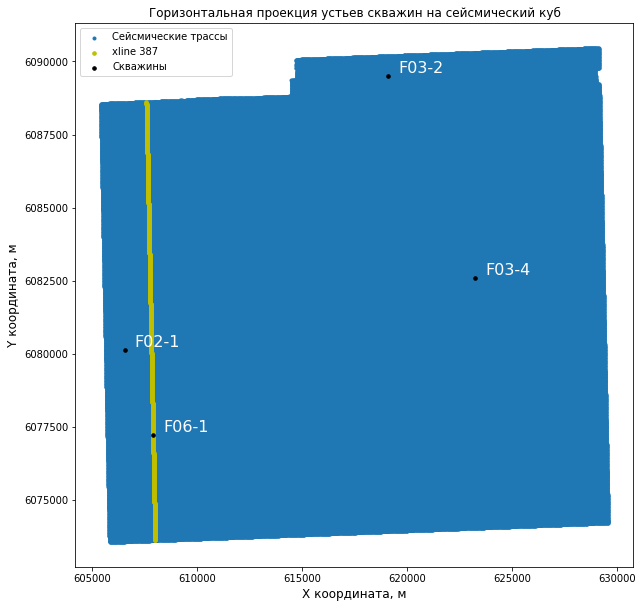

In [7]:
xline = 387
slicex = sourceX[CROSSLINE_3D == xline]
slicey = sourceY[CROSSLINE_3D == xline]
fig = plt.figure(figsize=(10, 10))
plt.scatter(trace_coords[::1, 0], trace_coords[::1, 1], marker='.')
plt.scatter(slicex, slicey, marker='.', s=50, c='y')
plt.scatter(wellheads['X-Coord'], wellheads['Y-Coord'], marker='.', s=50, c='k')
for id_, (x_, y_) in wellheads.iterrows():
    plt.annotate(id_, xy=[x_, y_], xytext=(10, 3), textcoords='offset points', c='w', fontsize=16)
plt.legend(['Сейсмические трассы', f'xline {xline}', 'Скважины'])
plt.title(f'Горизонтальная проекция устьев скважин на сейсмический куб')
plt.xlabel('X координата, м', fontsize=12)
plt.ylabel('Y координата, м', fontsize=12)
plt.show()

#### Визуализируем инлайн

675


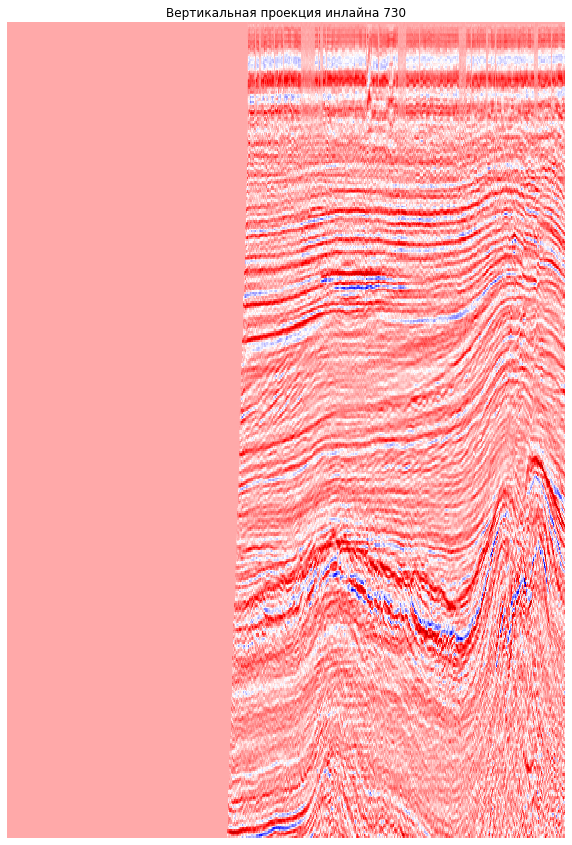

In [8]:
iline = 730
seismic_slice = slice_inline(iline)

fig = plt.figure(figsize=(10, 15))
plt.imshow(seismic_slice, cmap = 'seismic', aspect = 'auto')
plt.axis('off')
plt.title(f'Вертикальная проекция инлайна {iline}')
plt.show()

#### Визуализируем кросслайн

100


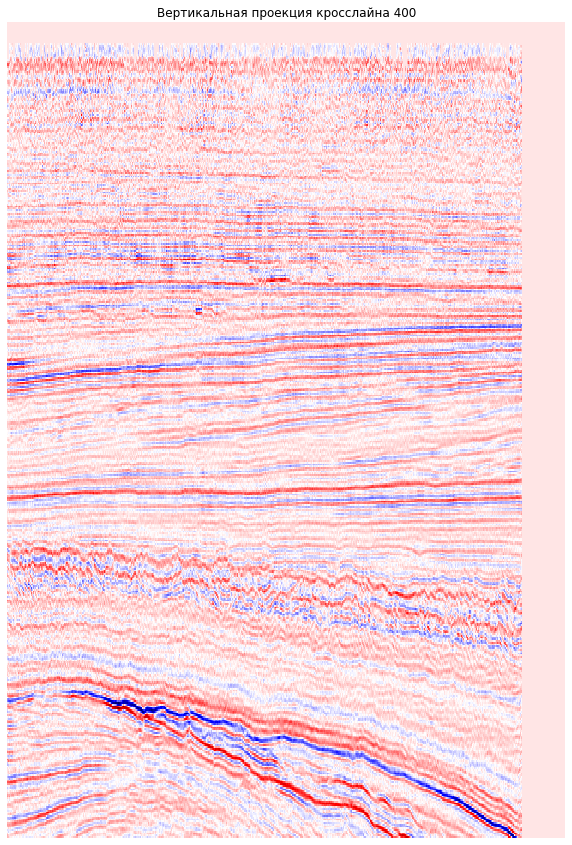

In [9]:
xline = 400
seismic_slice = slice_crossline(xline)

fig = plt.figure(figsize=(10, 15))
plt.imshow(seismic_slice, cmap = 'seismic', aspect = 'auto')
plt.axis('off')
plt.title(f'Вертикальная проекция кросслайна {xline}')
plt.show()

#### Проекция скважины F03-4

In [10]:
well_name = 'F03-4'

# читаем координаты сейсмического среза из подготовленного словаря `slice_coord_dict.pkl`
with open(slice_coord_path, 'rb') as f:
    slice_coord_dict = pickle.load(f)
iline_coords = slice_coord_dict['iline'][iline]

ptw = Point(*wellheads.loc[well_name, ['X-Coord', 'Y-Coord']])
pt1 = Point(*iline_coords[0])
pt2 = Point(*iline_coords[-1])
ptp = projection(pt1, pt2, ptw)

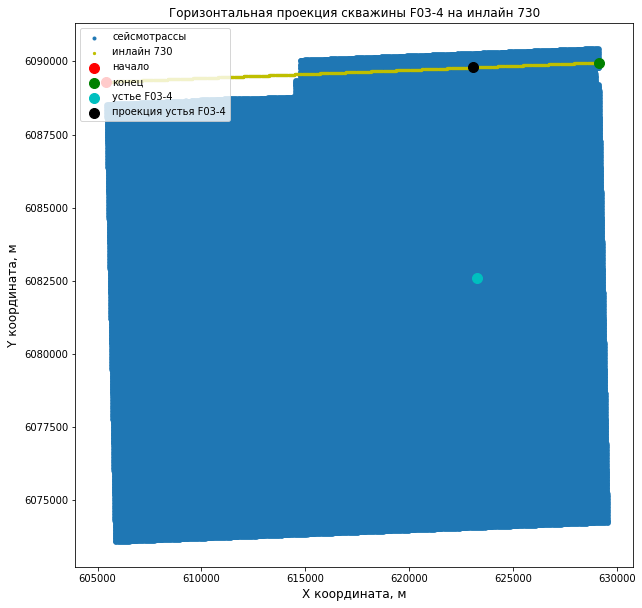

In [11]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(trace_coords[::1, 0], trace_coords[::1, 1], marker='.')
plt.scatter(iline_coords[:, 0], iline_coords[:, 1], marker='.', s=20, c='y')
plt.scatter(*pt1, marker='o', s=100, c='r')
plt.scatter(*pt2, marker='o', s=100, c='g')
plt.scatter(*ptw, marker='o', s=100, c='c')
plt.scatter(*ptp, marker='o', s=100, c='k')
plt.legend(['сейсмотрассы', f'инлайн {iline}', 'начало', 'конец', f'устье {well_name}', f'проекция устья {well_name}'])
plt.title(f'Горизонтальная проекция скважины {well_name} на инлайн {iline}')
plt.xlabel('X координата, м', fontsize=12)
plt.ylabel('Y координата, м', fontsize=12)
plt.show()

#### Читаем las файл в pandas data frame

In [12]:
las_df = pd.read_csv(data_dir / 'custom' / f'{well_name}.log.csv', delimiter='\t', na_values='1.000000e+30')
las_df

,Inline,Crossline,Time(ms),Density(kg/m3),Sonic(us/m),Gamma_Ray(API),Porosity(fraction),P_Impedance(Kg/m2s),P_Impedance_rel(Kg/m2s),Vp(Meter/second)
0,442,1007,-36.289898,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,442,1007,-36.130264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,442,1007,-35.970631,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,442,1007,-35.811000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,442,1007,-35.651363,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
12661,442,1007,1897.695312,NaN,NaN,9.182000,NaN,NaN,NaN,NaN
12662,442,1007,1897.829468,NaN,NaN,8.219700,NaN,NaN,NaN,NaN
12663,442,1007,1897.963501,NaN,NaN,7.394401,NaN,NaN,NaN,NaN
12664,442,1007,1898.097656,NaN,NaN,7.150000,NaN,NaN,NaN,NaN


#### Дополняем его координатами

In [13]:
idx = np.logical_and(las_df['Inline'].values[0] == INLINE_3D, las_df['Crossline'].values[0] == CROSSLINE_3D)
las_df['x'] = sourceX[idx][0]
las_df['y'] = sourceY[idx][0]
las_df = las_df.rename(columns={'Time(ms)': 't'})
las_df = las_df.loc[(0 <= las_df['t']) & (las_df['t'] <= nsamples * dt)]
las_df

,Inline,Crossline,t,Density(kg/m3),Sonic(us/m),Gamma_Ray(API),Porosity(fraction),P_Impedance(Kg/m2s),P_Impedance_rel(Kg/m2s),Vp(Meter/second),x,y
228,442,1007,0.106423,2078.340088,NaN,NaN,0.357300,4089730.0,-117335.000000,NaN,623264.9,6082596.6
229,442,1007,0.266060,2078.400000,NaN,NaN,0.357300,4089940.0,-121861.117188,NaN,623264.9,6082596.6
230,442,1007,0.425690,2078.400000,NaN,NaN,0.357300,4090040.0,-126388.000000,NaN,623264.9,6082596.6
231,442,1007,0.585324,2078.400000,NaN,NaN,0.357300,4090140.0,-130267.000000,NaN,623264.9,6082596.6
232,442,1007,0.744959,2078.400000,NaN,NaN,0.357200,4090240.0,-133602.078125,NaN,623264.9,6082596.6
...,...,...,...,...,...,...,...,...,...,...,...,...
12286,442,1007,1847.445679,2240.300000,416.183990,33.532902,0.256100,5382960.0,34535.800781,2402.780029,623264.9,6082596.6
12287,442,1007,1847.575073,2240.300000,416.183990,33.250000,0.256100,5382960.0,27560.699219,2402.780029,623264.9,6082596.6
12288,442,1007,1847.704590,2240.278564,416.196198,33.250351,0.256113,5382960.0,20585.724609,2402.642090,623264.9,6082596.6
12289,442,1007,1847.833984,2213.876465,431.189270,33.683521,0.272615,5143550.0,13610.624023,2319.101318,623264.9,6082596.6


In [14]:
vertical_grid = np.arange(nsamples) * dt
target, mask = gen_tgt_mask(iline_coords, vertical_grid, las_df, carotage_types=['P_Impedance(Kg/m2s)'], well_width=20)

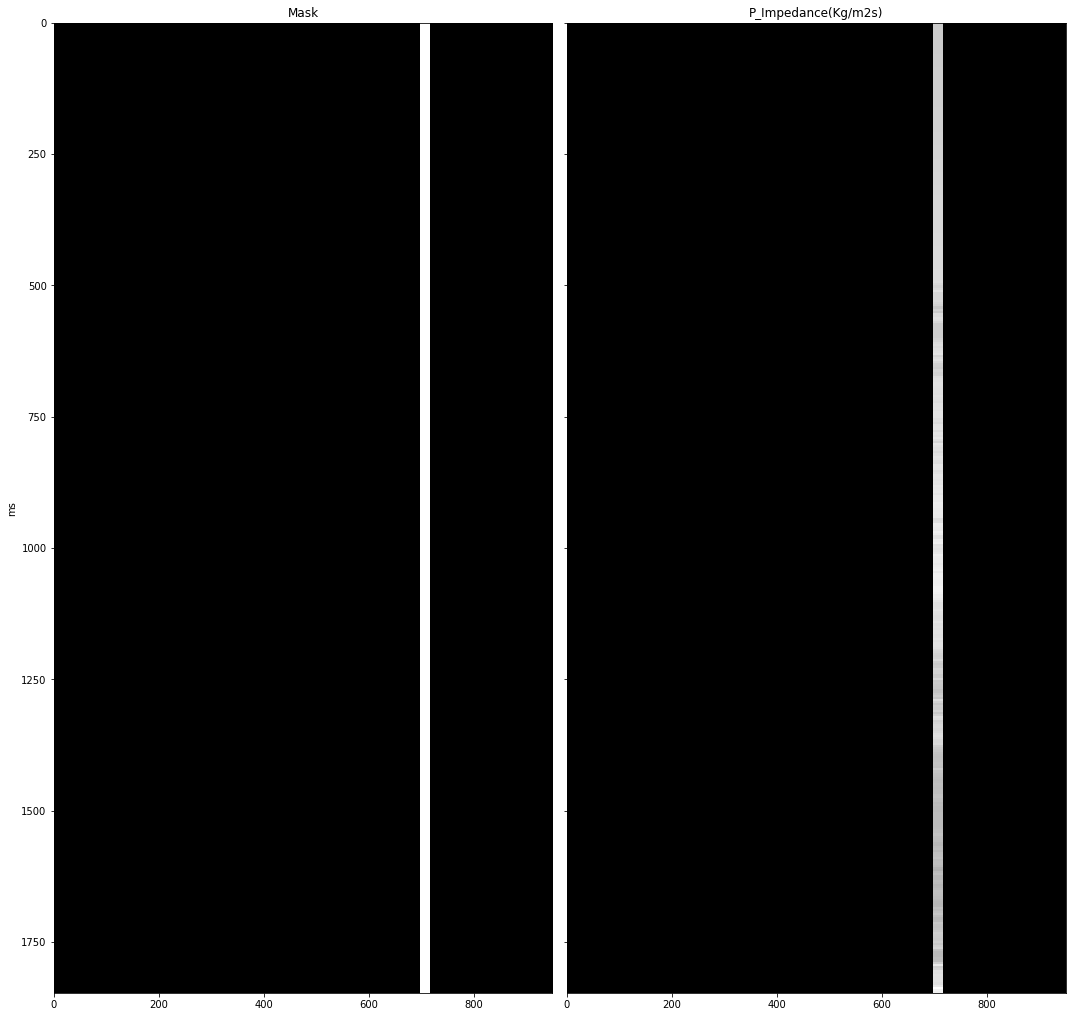

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 30), sharey=True)
ax1.imshow(mask[..., 0], cmap='Greys_r', extent=[0, mask.shape[1] - 1, nsamples * dt - 1, 0])
ax1.set_title('Mask')
ax1.set_ylabel('ms', fontsize = '10')
ax2.imshow(target[..., 0], cmap='Greys_r', extent=[0, mask.shape[1] - 1, nsamples * dt - 1, 0])
ax2.set_title('P_Impedance(Kg/m2s)')
plt.tight_layout()
plt.show()

### Проекция множества скважин

In [16]:
well_list = ['F02-1', 'F03-2']
carotage_types = ['Gamma_Ray', 'P_Impedance']
target, mask = project_wells_onto_slice(740, 'xline', well_list, carotage_types=carotage_types, well_width=20)

  F02-1
  F03-2


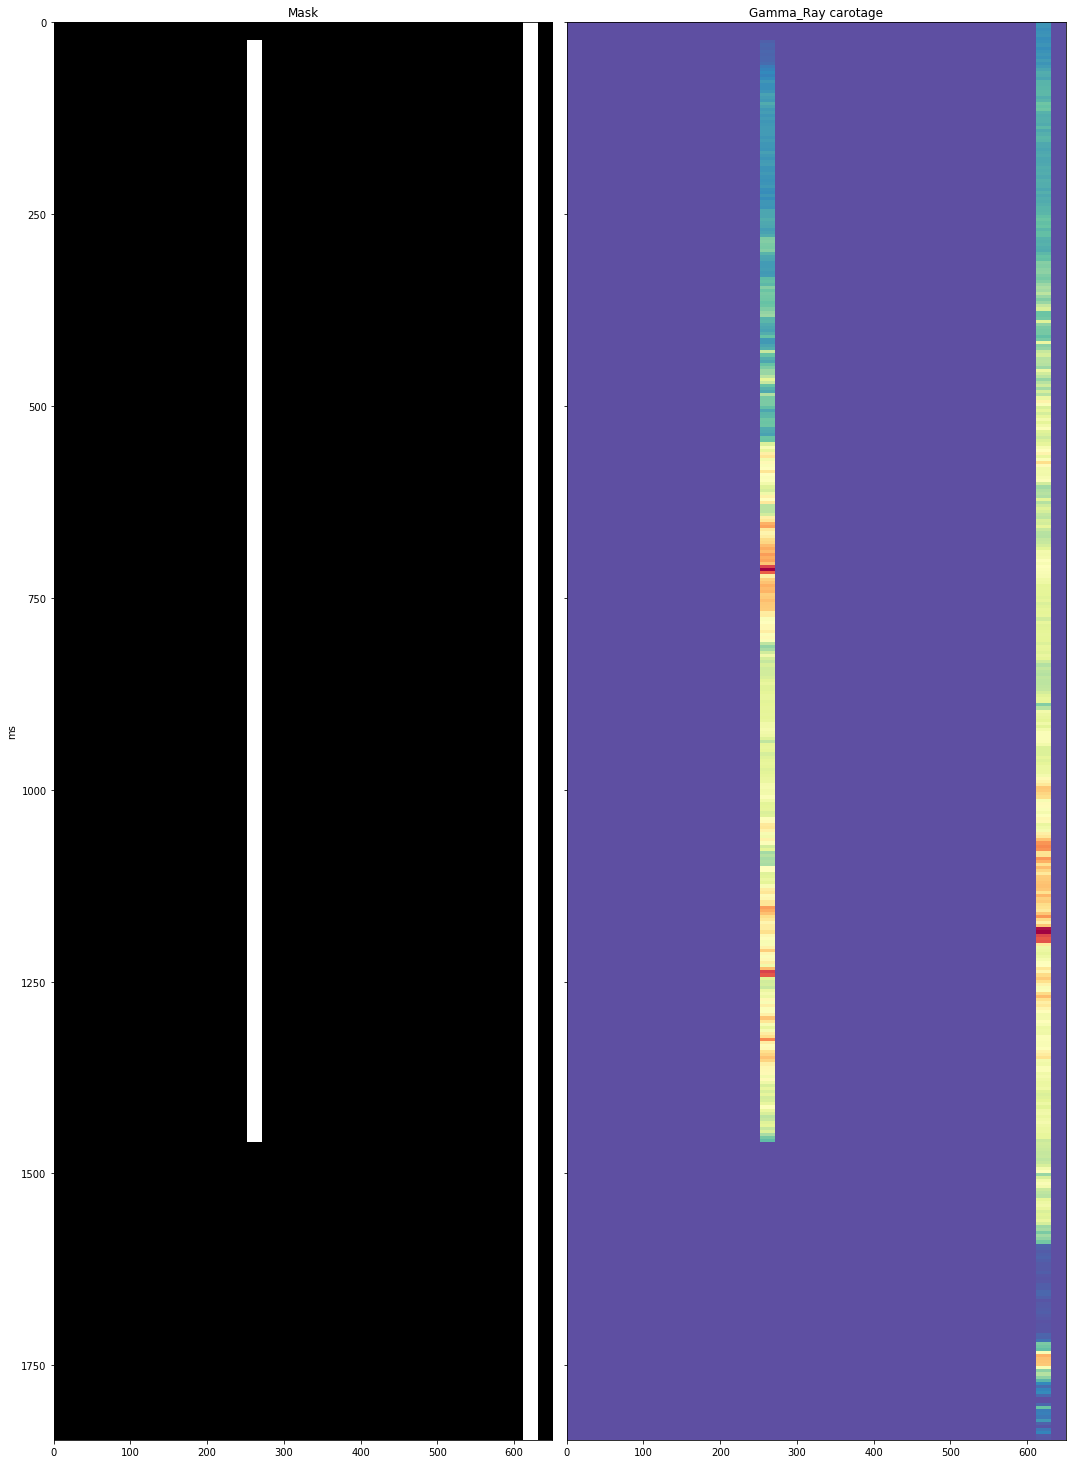

In [17]:
# визуализируем проекции Gamma_Ray каротажей
carotage_type = 'Gamma_Ray'
index = carotage_types.index(carotage_type)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 30), sharey=True)
ax1.imshow(mask[..., index], cmap='Greys_r', extent=[0, target.shape[1] - 1, nsamples * dt - 1, 0])
ax1.set_title('Mask')
ax1.set_ylabel('ms', fontsize = '10')
ax2.imshow(target[..., index], cmap='Spectral_r', extent=[0, target.shape[1] - 1, nsamples * dt - 1, 0])
ax2.set_title(f'{carotage_type} carotage')
plt.tight_layout()
plt.show()

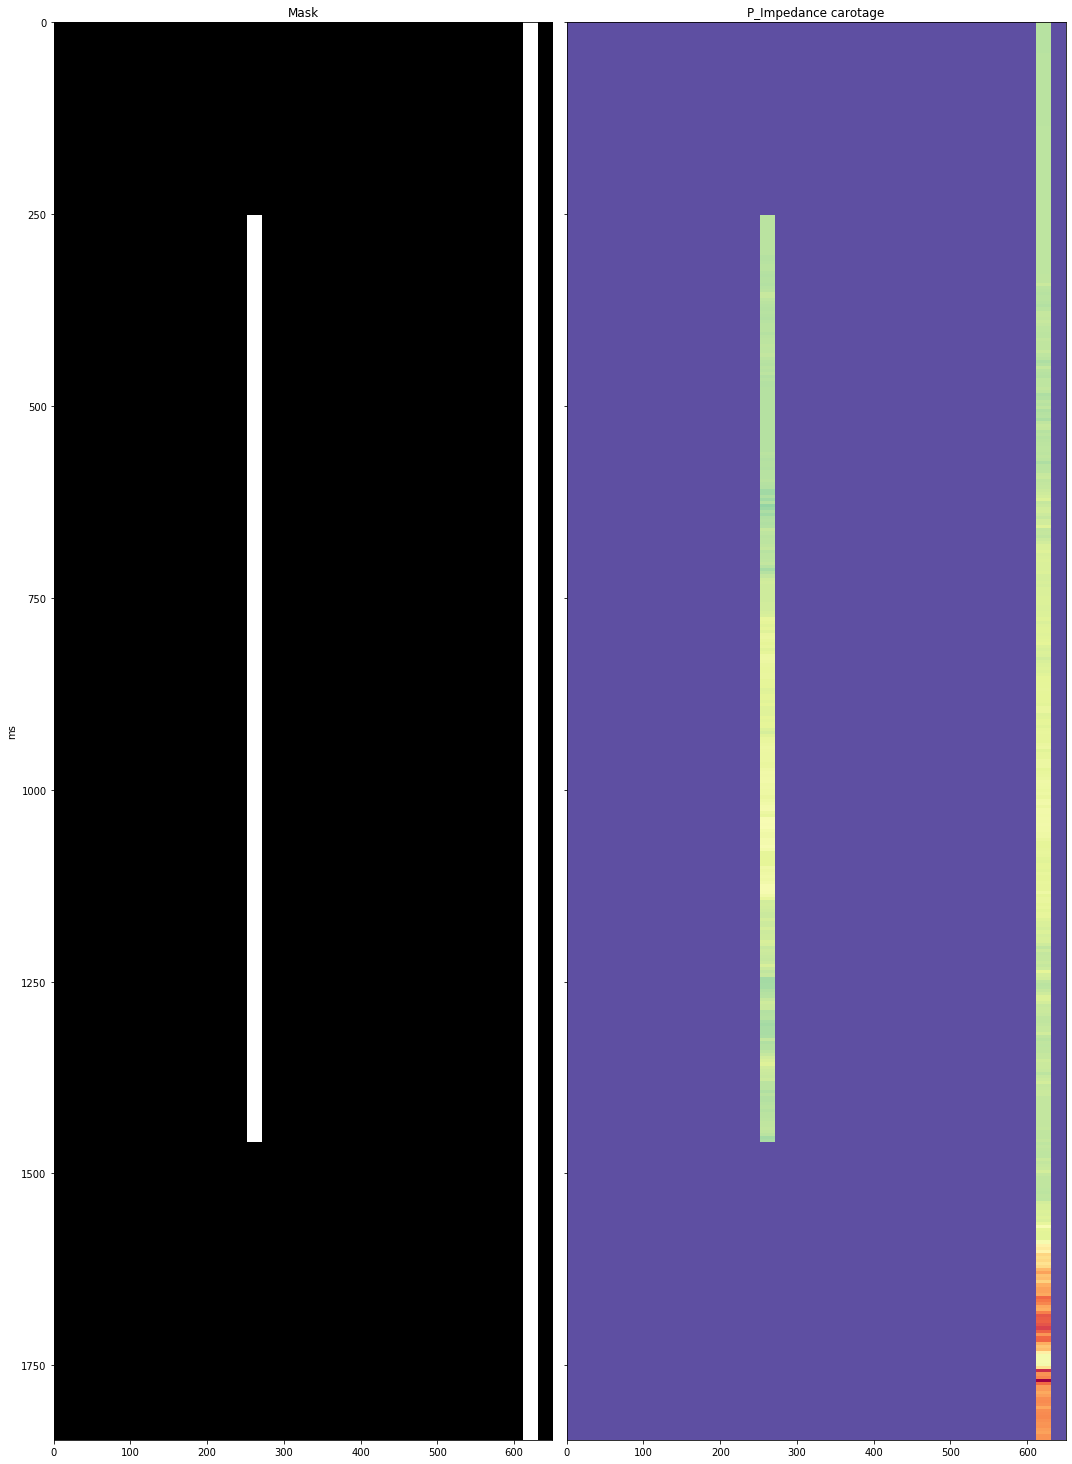

In [18]:
# визуализируем проекции P_Impedance каротажей
carotage_type = 'P_Impedance'
index = carotage_types.index(carotage_type)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 30), sharey=True)
ax1.imshow(mask[..., index], cmap='Greys_r', extent=[0, target.shape[1] - 1, nsamples * dt - 1, 0])
ax1.set_title('Mask')
ax1.set_ylabel('ms', fontsize = '10')
ax2.imshow(target[..., index], cmap='Spectral_r', extent=[0, target.shape[1] - 1, nsamples * dt - 1, 0])
ax2.set_title(f'{carotage_type} carotage')
plt.tight_layout()
plt.show()

#### Визуализируем подготовленные данные для тренировки на одиночных каротажах

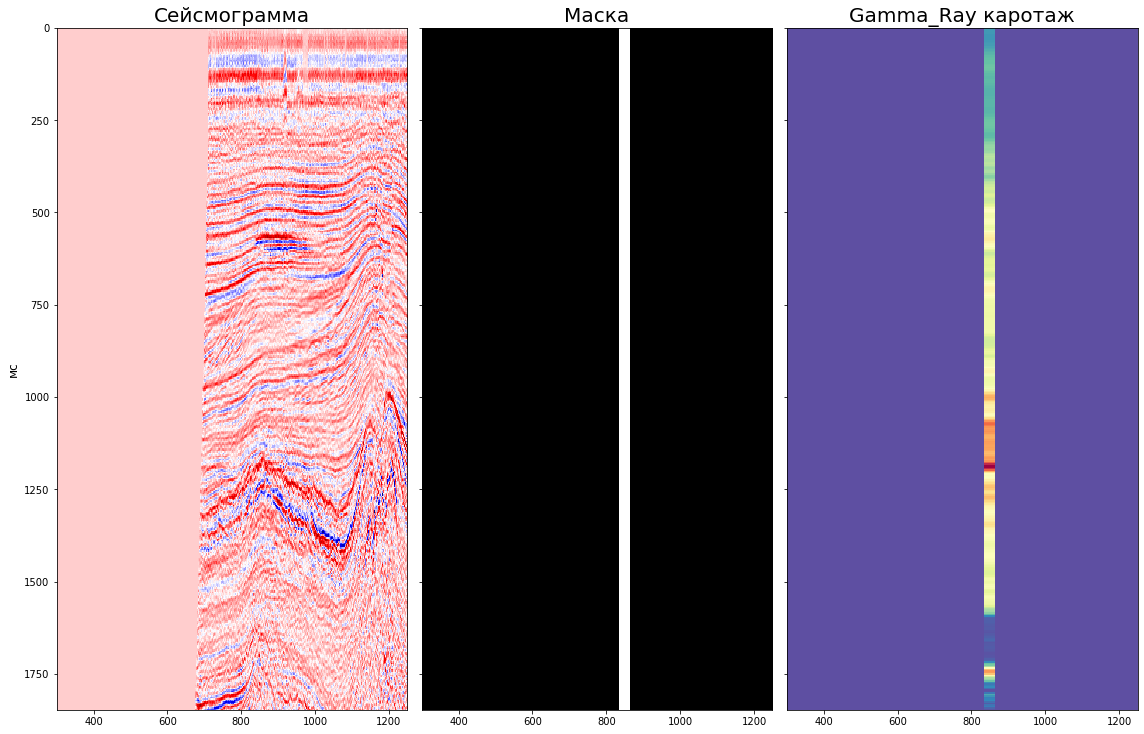

In [27]:
fl = 'iline_732_F03-2.pkl'
extent = [min(ilines), max(ilines), nsamples * dt - 1, 0] if 'xline' in fl else [min(xlines), max(xlines), nsamples * dt - 1, 0]
with open(slices_dir / fl, 'rb') as f:
    slice_data = pickle.load(f)

fontsize = 20
carotage_type = 'Gamma_Ray'
seismic_ver = slice_data['seismic']
mask_ver = slice_data['projections'][carotage_type]['mask']
target_ver = slice_data['projections'][carotage_type]['target']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 14), sharey=True)
ax1.imshow(seismic_ver, cmap='seismic', extent=extent)
ax1.set_title('Сейсмограмма', fontsize=fontsize)
ax1.set_ylabel('мс', fontsize=12)

ax2.imshow(mask_ver, cmap='Greys_r', extent=extent)
ax2.set_title('Маска', fontsize=fontsize)

ax3.imshow(target_ver, cmap='Spectral_r', extent=extent)
ax3.set_title(f'{carotage_type} каротаж', fontsize=fontsize)
plt.tight_layout()
plt.show()

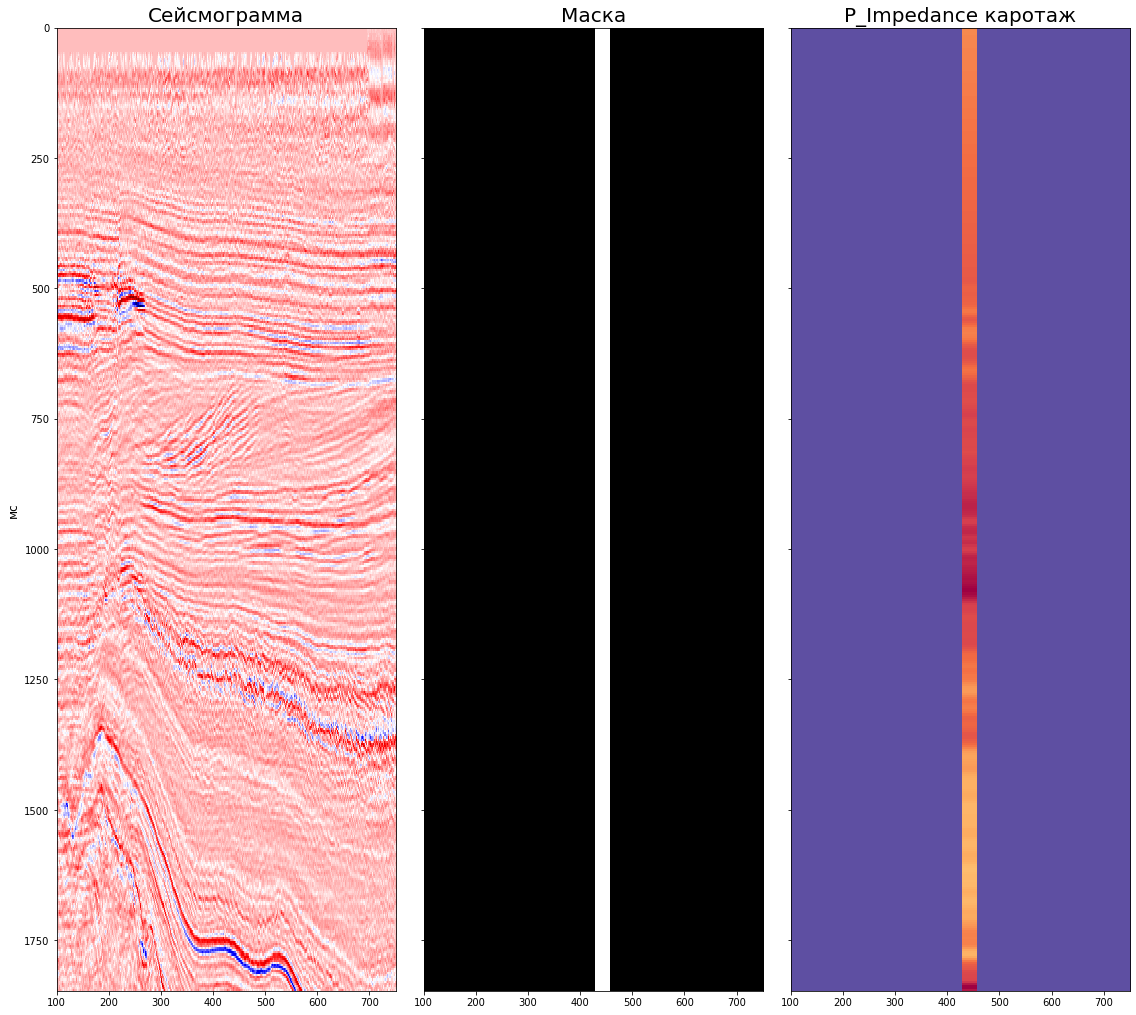

In [28]:
fl = 'xline_1006_F03-4.pkl'
extent = [min(ilines), max(ilines), nsamples * dt - 1, 0] if 'xline' in fl else [min(xlines), max(xlines), nsamples * dt - 1, 0]
with open(slices_dir / fl, 'rb') as f:
    slice_data = pickle.load(f)

fontsize = 20
carotage_type = 'P_Impedance'
seismic_ver = slice_data['seismic']
mask_ver = slice_data['projections'][carotage_type]['mask']
target_ver = slice_data['projections'][carotage_type]['target']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 14), sharey=True)
ax1.imshow(seismic_ver, cmap='seismic', extent=extent)
ax1.set_title('Сейсмограмма', fontsize=fontsize)
ax1.set_ylabel('мс', fontsize=12)

ax2.imshow(mask_ver, cmap='Greys_r', extent=extent)
ax2.set_title('Маска', fontsize=fontsize)

ax3.imshow(target_ver, cmap='Spectral_r', extent=extent)
ax3.set_title(f'{carotage_type} каротаж', fontsize=fontsize)
plt.tight_layout()
plt.show()